# Sales Forecast

## Step 1: Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np                    
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import T1_functions as T1
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import TimeSeriesSplit 
from itertools import product 
from tqdm import tqdm_notebook
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Step 2: Import and Inspect Data

In [2]:
df = pd.read_csv('t1-dataset.csv')
df.head()

,order_id,user_id,city,deliverydate
0,595,450,Montreal,2017-03-04 06:35:28
1,646,13,Montreal,2017-03-08 20:54:56
2,561,450,Montreal,2017-03-12 19:13:55
3,644,13,Montreal,2017-03-16 20:07:55
4,568,13,Montreal,2017-03-17 23:15:06


In [3]:
# Check whether null values exsit
df.isnull().sum()

order_id        0
user_id         0
city            0
deliverydate    0
dtype: int64

In [4]:
# Information about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12227 entries, 0 to 12226
Data columns (total 4 columns):
order_id        12227 non-null int64
user_id         12227 non-null int64
city            12227 non-null object
deliverydate    12227 non-null object
dtypes: int64(2), object(2)
memory usage: 382.2+ KB


In [5]:
#Aassign timestamps as indexes of dataframe
format_datetime = '%Y-%m-%dT%H:%M:%S'
df['deliverydate_datetime'] = pd.to_datetime(df['deliverydate'], format=format_datetime)
df = df.set_index(pd.DatetimeIndex(df['deliverydate_datetime']))
df.tail()

,order_id,user_id,city,deliverydate,deliverydate_datetime
deliverydate_datetime,,,,,
2019-07-29 13:33:00,15244,3649,Toronto,2019-07-29 13:33:00,2019-07-29 13:33:00
2019-07-29 13:36:00,15238,6281,Montreal,2019-07-29 13:36:00,2019-07-29 13:36:00
2019-07-29 13:48:00,15242,5646,Toronto,2019-07-29 13:48:00,2019-07-29 13:48:00
2019-07-29 13:48:00,15241,3744,Toronto,2019-07-29 13:48:00,2019-07-29 13:48:00
2019-07-29 13:52:00,15243,2863,Toronto,2019-07-29 13:52:00,2019-07-29 13:52:00


## Step 3: Exploratory Data Analysis

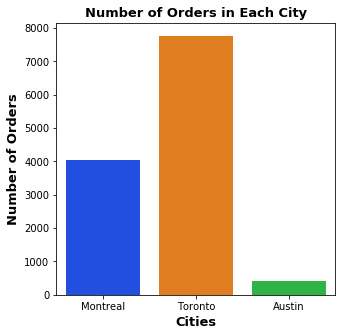

In [6]:
# Total number of orders in each city
fig = plt.figure(figsize=(5, 5))
ax = sns.countplot(x = 'city', data=df, palette="bright")
ax.set_xlabel('Cities', fontsize=13, weight='bold')
ax.set_ylabel('Number of Orders', fontsize=13, weight='bold')
ax.set_title('Number of Orders in Each City', fontsize=13, weight='bold');

<Figure size 432x288 with 0 Axes>

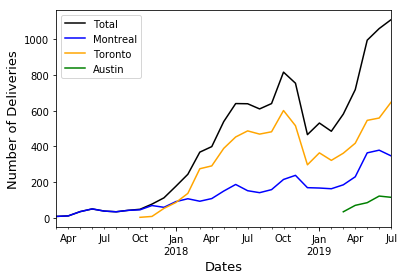

In [7]:
# Count number of orders monthly 
resample_method = 'M'
df_counts = df.resample(resample_method, how={'order_id':'count'})
df_counts.rename(columns={'order_id': 'Total'}, inplace=True)

# Number of orders per city 
df_counts['Montreal'] = df[df['city'].str.contains('Montreal')].resample(resample_method,how={'order_id':'count'})
df_counts['Toronto'] = df[df['city'].str.contains('Toronto')].resample(resample_method,how={'order_id':'count'})
df_counts['Austin'] = df[df['city'].str.contains('Austin')].resample(resample_method,how={'order_id':'count'})

# Plot trends in each city
plt.figure();
df_counts.plot(color=['black','blue','orange','green']);
plt.xlabel('Dates', fontsize=13)
plt.ylabel('Number of Deliveries', fontsize=13);

In [8]:
# Create dataframes for each city
data_montreal = T1.create_city_df('Montreal', df_counts)
data_toronto = T1.create_city_df('Toronto', df_counts)
data_austin = T1.create_city_df('Austin', df_counts)

Montreal: 29 data points
Toronto: 22 data points
Austin: 5 data points


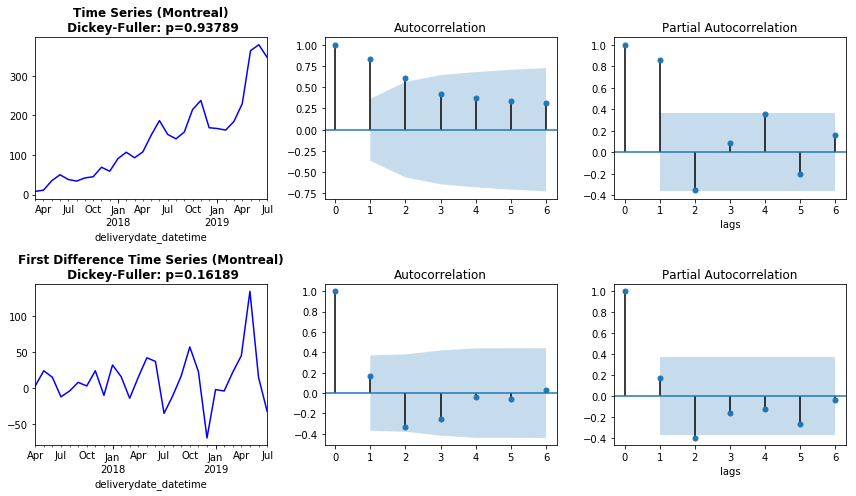

In [9]:
# Time Series check for Montreal
T1.plot_ts_diff(data_montreal.y, lags = 6, 
                city = 'Montreal', 
                plot_color = 'blue', 
                log_binary = 0)

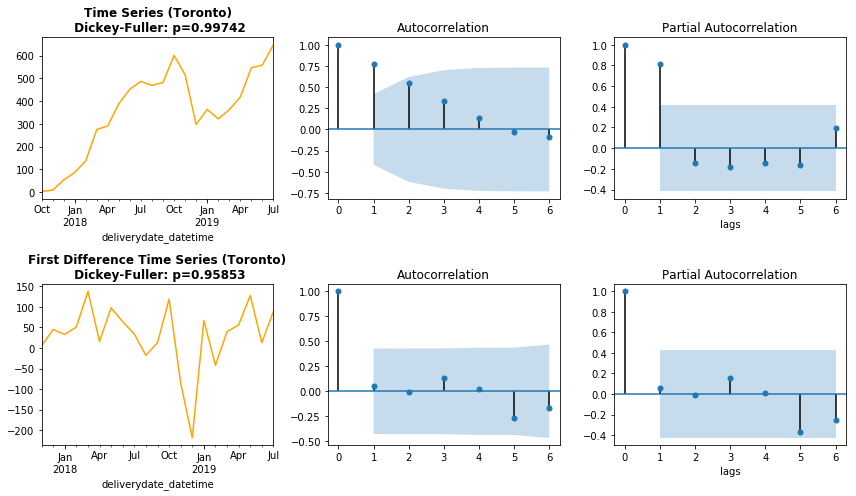

In [10]:
# Time Series check for Toronto
T1.plot_ts_diff(data_toronto.y, lags = 6,
                city = 'Toronto',
                plot_color = 'orange',
                log_binary = 0)

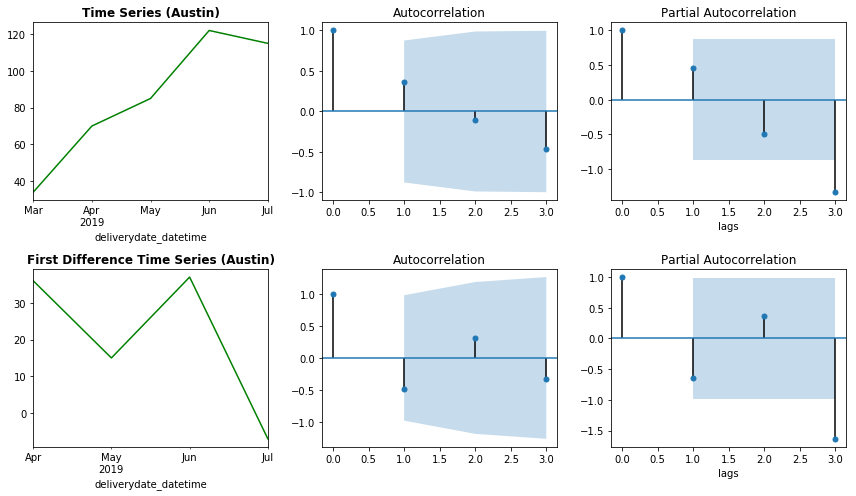

In [11]:
# Time Series check for Austin
T1.plot_ts_diff(data_austin.y, lags = 3,
                city = 'Austin',
                plot_color = 'green',
                log_binary = 0)

## Step 4:  Time Series Stationary Transformation

In [12]:
# Log-transform of the time series
log_data_toronto = np.log(data_toronto)
log_data_montreal = np.log(data_montreal)

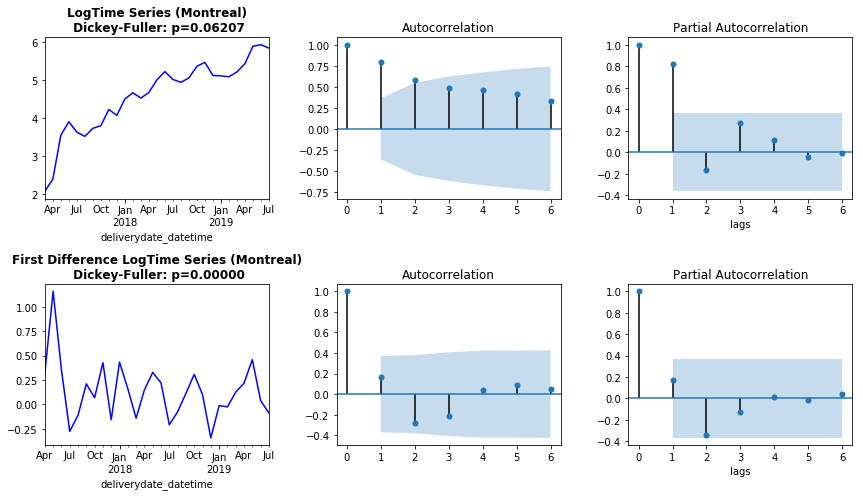

In [13]:
T1.plot_ts_diff(log_data_montreal.y, lags = 6, 
                city = 'Montreal', 
                plot_color = 'blue',
                log_binary = 1)

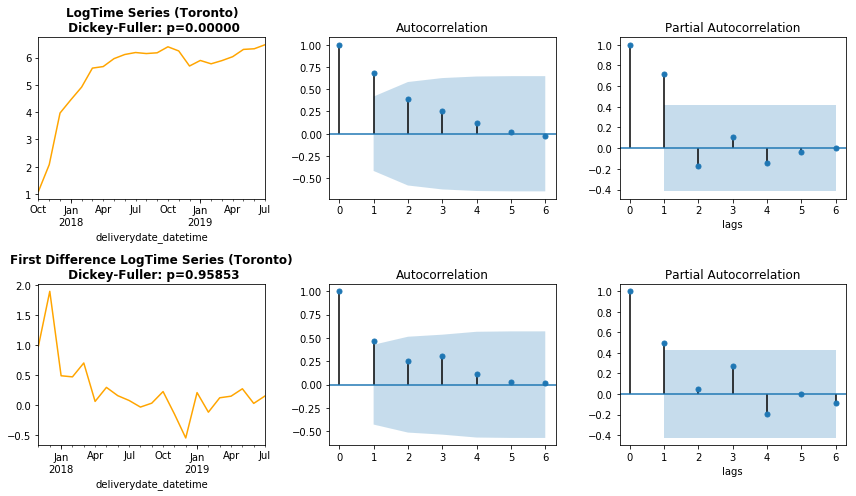

In [14]:
T1.plot_ts_diff(log_data_toronto.y, lags = 6, 
                city = 'Toronto', 
                plot_color = 'orange', 
                log_binary = 1)

## Step 5: Time Series Modeling (ARIMA) - Montreal and Toronto

In [15]:
# setting initial values and some bounds from ARIMA parameters 
ps = range(2, 5)
d = range(1, 3)
qs = range(2, 5)

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, d)
parameters_list = list(parameters)
print('Total Combinations of Parameters: ' + str(len(parameters_list)))

Total Combinations of Parameters: 18


#### Montreal

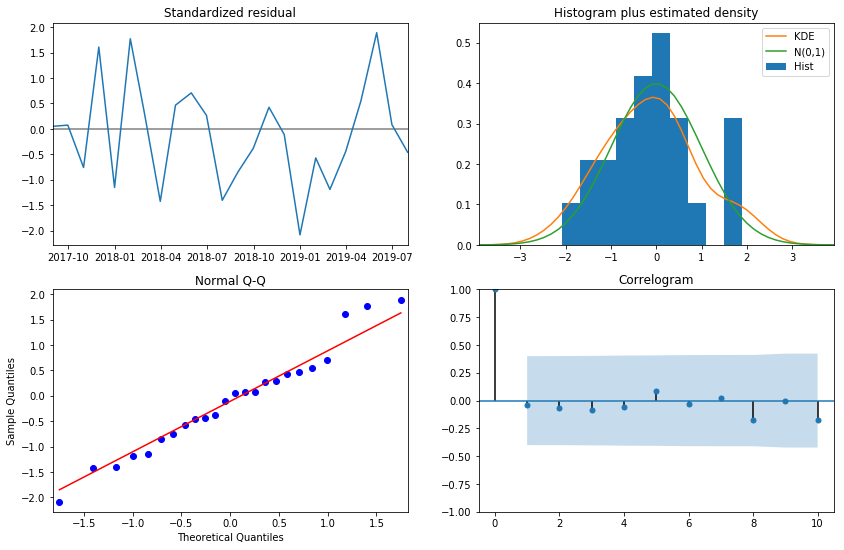

In [16]:
# GridSearch and Walkforward Cross Validation (Montreal)
result_table_Montreal = T1.optimizeSARIMA(log_data_montreal.y, parameters_list)

# Set the parameters that give the lowest MAPE
p, q, d = result_table_Montreal.parameters[0]

# Fit the model with the optimized parameters
Montreal_model=sm.tsa.statespace.SARIMAX(log_data_montreal.y
                                     , order=(p, d, q)
                                     , enforce_stationarity = False
                                     , enforce_invertibility = False).fit(disp=-1)
# Show Diagnostics of Montreal
Montreal_model.plot_diagnostics(figsize=(14,9))
plt.show()

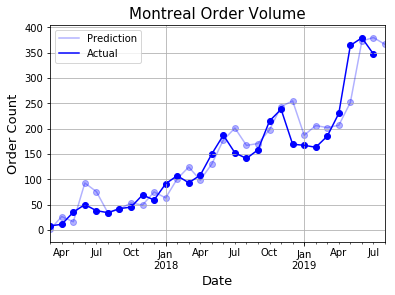

In [17]:
# Make final predictions 
Montreal_predictions = np.exp(Montreal_model.predict(start = 0, end = len(data_montreal.y)))

# Plotting Predictions and Actual
T1.prediction_plot(Montreal_predictions, data_montreal.y, 'Montreal', 'blue')

In [18]:
result_table_Montreal.head()

,parameters,MAPE,AIC
0,"(3, 2, 2)",3.321154,4.893161
1,"(2, 2, 1)",3.344681,8.133612
2,"(2, 2, 2)",3.346133,3.727028
3,"(3, 2, 1)",3.700394,4.864431
4,"(4, 2, 1)",3.811463,5.530383


#### Toronto

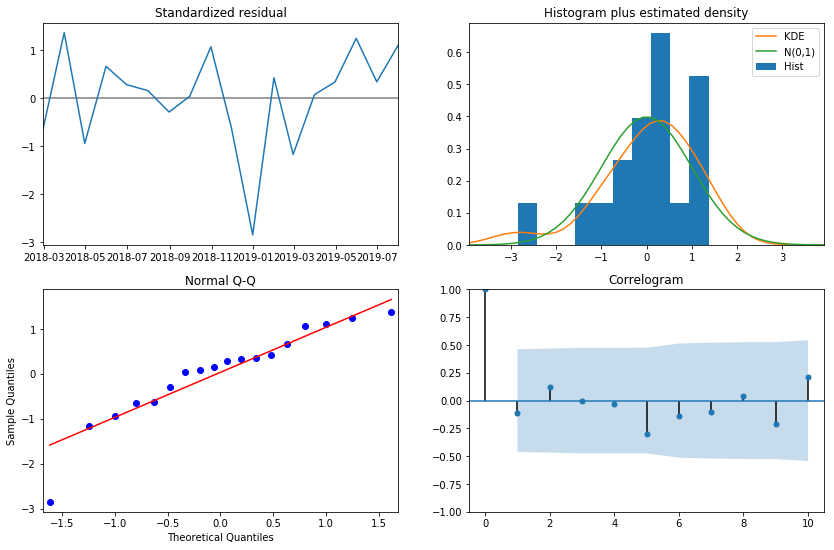

In [19]:
# GridSearch and Walkforward Cross Validation (Toronto)
result_table_Toronto = T1.optimizeSARIMA(log_data_toronto.y, parameters_list)

# Set the parameters that give the lowest MAPE
p, q, d = result_table_Toronto.parameters[0]

# Fit the model with the optimized parameters
Toronto_model=sm.tsa.statespace.SARIMAX(log_data_toronto.y
                                     , order=(p, d, q)
                                     , enforce_stationarity = False
                                     , enforce_invertibility = False).fit(disp=-1)
# Show Diagnostics of Toronto
Toronto_model.plot_diagnostics(figsize=(14,9))
plt.show()

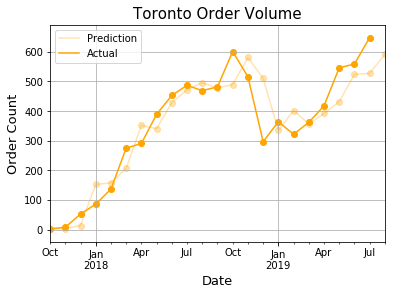

In [20]:
# Make final predictions 
Toronto_predictions = np.exp(Toronto_model.predict(start = 0, end = len(data_toronto.y)))

# Plotting Predictions and Actual
T1.prediction_plot(Toronto_predictions, data_toronto.y, 'Toronto', 'orange')

## Step 6: Time Series Modeling (Holt's Linear) - Austin

In [21]:
# Setting initial values for grid searching
smooth_lvl = np.arange(0.0, 1.0, 0.1)
smooth_slope = np.arange(0.0, 1.0, 0.1)

# Creating list with all the possible combinations of parameters
parameters = product(smooth_lvl, smooth_slope)
parameters_list = list(parameters)
len(parameters_list)

100

In [22]:
# GridSearch and Walkforward Cross Validation (Montreal)
result_table_Austin = T1.optimizeHOLT(parameters_list, data_austin.y)

# Set the parameters that give the lowest MAPE
smooth_lvl, smooth_slope = result_table_Austin.parameters[0]

# Fit the model with the optimized parameters
Austin_fit = Holt(data_austin.y).fit(smoothing_level= smooth_lvl, smoothing_slope = smooth_slope)

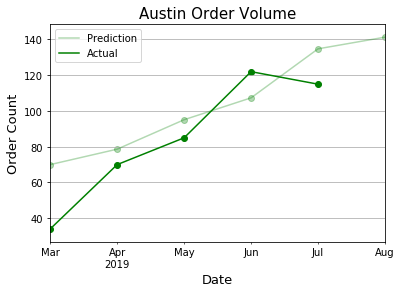

In [23]:
# Make final predictions 
Austin_predictions = Austin_fit.forecast(1).rename("Optimized")
Austin_predictions = pd.concat([Austin_fit.fittedvalues, Austin_predictions])

# Plotting Predictions and Actual
T1.prediction_plot(Austin_predictions, data_austin.y, 'Austin', 'green')

## Step 7: Naive Persistence Model

In [24]:
# Predictions for August in each city
AU_baseline_aug = int(data_austin.y[-1])
TO_baseline_aug = int(data_toronto.y[-1])
MO_baseline_aug = int(data_montreal.y[-1])

# MAPE in each city
AU_baseline_MAPE = round(T1.naive_persistence(data_austin.y),2)
TO_baseline_MAPE = round(T1.naive_persistence(np.log(data_toronto.y)),2)
MO_baseline_MAPE = round(T1.naive_persistence(np.log(data_montreal.y)),2)


## Step 8: Output Final Predictions

In [25]:
# Predictions for August in each city
AU_aug = int(round(Austin_predictions[-1]))
TO_aug = int(round(Toronto_predictions[-1]))
MO_aug = int(round(Montreal_predictions[-1]))

AU_MAPE = round(result_table_Austin.MAPE[0],2)
TO_MAPE = round(result_table_Toronto.MAPE[0],2)
MO_MAPE = round(result_table_Montreal.MAPE[0],2)

# Generate dataframe with predictions for each city
predictions = {'Aug Order Volume':[MO_aug, TO_aug, AU_aug],
               'Mean Absolute Percentage Error':[MO_MAPE, TO_MAPE, AU_MAPE],
               'Aug Order Volume (Baseline Model)':[MO_baseline_aug, TO_baseline_aug, AU_baseline_aug],
               'Mean Absolute Percentage Error (Baseline Model)':[MO_baseline_MAPE, TO_baseline_MAPE, AU_baseline_MAPE]}

# Creates pandas DataFrame. 
df_aug_predict = pd.DataFrame(predictions, index =['Montreal', 'Toronto', 'Austin']) 
# df_aug_predict['Aug Order Volume'].to_csv('T1_predictions.csv', header = True)

In [26]:
df_aug_predict['Aug Order Volume']

Montreal    366
Toronto     591
Austin      141
Name: Aug Order Volume, dtype: int64